# Deep Reinforcement learning with TF-Agents

-----


The goal of this project is to implement reinforcement agents with following setps:

* Choose one environment from [OpenAI Gym](https://gym.openai.com/envs/#classic_control)

* Choose one agent from [tf.agents library](https://github.com/tensorflow/agents)

* Study and explain the policy learning method for the particular agent of your choice

* Use the training procedure in the [tutorial](https://github.com/lydiahsu/AML_Fall_2019/blob/master/TF_agents_intro.ipynb) as a reference and implement your own agent

* Show the performance of your agent by letting the trained agent to play several random games and compare the total rewards with the maximum possible rewards

We have modified the goal to implement both Double Q-Network and Soft Actor Critic on three classic games with discrete action spaces. Since SAC doesn't already have an implementation in the discrete setting, we have written that ourselves 



## Choosing agents from `tf.library`

We chose __Deep Q Network (DQN)__ and __Soft Actor Critic(SAC)__ agents. In the following sections, we will implement the agents through `tf_agent` and run them on the `MountainCar-v0`, `Acrobot-v1` and `CartPole-v0` environments. Towards the end, we also tried SAC agent for the Atari Game: Boxing

### Setup 

install libraries with correct version of TensorFlow

In [0]:
!pip install PILLOW
!pip install tf-agents-nightly
try:
  %%tensorflow_version 2.x
except:
  pass

     |████████████████████████████████| 849kB 2.8MB/s 
     |████████████████████████████████| 51kB 9.7MB/s 
     |████████████████████████████████| 3.0MB 51.8MB/s 
  Found existing installation: gin-config 0.2.1
    Uninstalling gin-config-0.2.1:
      Successfully uninstalled gin-config-0.2.1
TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver, dynamic_episode_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics, py_metric, tf_py_metric
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

### Setup Environment
We tried DQN on three environments, MountainCar-v0, Acrobot-v1 and CartPole-v0. To run the code for the others, just update the env_name variable here. For CartPole, the hyperparameters also require a small change. Please be mindful of that

In [0]:
env_name = 'MountainCar-v0'

In [0]:
train_py_env = suite_gym.load(env_name)

print('Observation Spec:')
print(train_py_env.time_step_spec().observation)
print('Reward Spec:')
print(train_py_env.time_step_spec().reward)
print('Action Spec:')
print(train_py_env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(2,), dtype=dtype('float32'), name='observation', minimum=[-1.2  -0.07], maximum=[0.6  0.07])
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=2)


In [0]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

## Run DQN First

### Hyperparameters

#### The default parameters are set for MountainCar and Acrobot. For CartPole, we changed the batch_size to 64 and learning_rate to 1e-3. Everything else remains unchanged

In [0]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size =   128# @param {type:"integer"}
learning_rate = 1e-4  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

### Agent

The algorithm used is __DQN__. The __DQN__ agent can be used in any environment which has a discrete action space. At the heart of a __DQN__ Agent is a `QNetwork`, a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment.

Use `tf_agents.networks.q_network` to create a `QNetwork`, passing in the `observation_spec`, `action_spec`, and a tuple describing the number and size of the model's hidden layers.

In [0]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params
)

Now use `tf_agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter.

In [0]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

dqn_agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter
)

dqn_agent.initialize()

### Replay Buffer

The replay buffer keeps track of data collected from the environment. This tutorial uses `tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer`, as it is the most common. 

The constructor requires the specs for the data it will be collecting. This is available from the agent using the `collect_data_spec` method. The batch size and maximum buffer length are also required.

In [0]:
dqn_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=dqn_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

### Data Collection with customized metric

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

In [0]:
class MaxEpisodeScoreMetric(py_metric.PyStepMetric):
  def __init__(self, name='MaxEpisodeScoreMetric'):
    super(py_metric.PyStepMetric, self).__init__(name)
    self.rewards = []
    self.discounts = []
    self.max_discounted_reward = None
    self.reset()
  def reset(self):
    self.rewards = []
    self.discounts = []
    self.max_discounted_reward = None
  def call(self, trajectory):
    self.rewards += trajectory.reward
    self.discounts += trajectory.discount
    
    if(trajectory.is_last()):      
      adjusted_discounts = [1.0] + self.discounts # because a step has its value + the discount of the NEXT step (Bellman equation)
      adjusted_discounts = adjusted_discounts[:-1] # dropping the discount of the last step because it is not followed by a next step, so the value is useless
      discounted_reward = np.sum(np.multiply(self.rewards, adjusted_discounts))
      #print(self.rewards, adjusted_discounts, discounted_reward)
      
      if self.max_discounted_reward == None:
        self.max_discounted_reward = discounted_reward
      
      if discounted_reward > self.max_discounted_reward:
        self.max_discounted_reward = discounted_reward
        
      self.rewards = []
      self.discounts = []
  def result(self):
    return self.max_discounted_reward

class TFMaxEpisodeScoreMetric(tf_py_metric.TFPyMetric):

  def __init__(self, name='MaxEpisodeScoreMetric', dtype=tf.float32):
    py_metric = MaxEpisodeScoreMetric()

    super(TFMaxEpisodeScoreMetric, self).__init__(
        py_metric=py_metric, name=name, dtype=dtype)

In [0]:
def collect_training_data(agent, replay_buffer):
  dynamic_step_driver.DynamicStepDriver(
      train_env,
      agent.collect_policy,
      observers=[replay_buffer.add_batch],
      num_steps=initial_collect_steps).run()

def train_agent(agent, replay_buffer):
  dataset = replay_buffer.as_dataset(
      sample_batch_size=batch_size,
      num_steps=2)

  iterator = iter(dataset)

  loss = None
  for _ in tqdm(range(num_iterations)):
    trajectories, _ = next(iterator)
    loss = agent.train(experience=trajectories)
  
  print('\nTraining loss: ', loss.loss.numpy())
  return loss.loss.numpy()

In [0]:
def evaluate_agent(agent):
  max_score = TFMaxEpisodeScoreMetric() 
  observers = [max_score]
  driver = dynamic_episode_driver.DynamicEpisodeDriver(
      train_env, agent.policy, observers, num_episodes=num_eval_episodes)

  final_time_step, policy_state = driver.run()

  print('Max test score:', max_score.result().numpy())
  return max_score.result().numpy()

### Training the agent

Two thing must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
dqn_training_loss = []
dqn_max_test_score = []

with tf.device('/device:GPU:0'):
  for i in range(10):
    print('Step ', i+1)
    collect_training_data(dqn_agent, dqn_replay_buffer)
    dqn_training_loss.append(train_agent(dqn_agent, dqn_replay_buffer))
    dqn_max_test_score.append(evaluate_agent(dqn_agent))

Step  1


100%|██████████| 20000/20000 [08:20<00:00, 39.98it/s]



Training loss:  7.656824
Max test score: -200.0
Step  2


100%|██████████| 20000/20000 [08:13<00:00, 40.50it/s]



Training loss:  15.141324
Max test score: -200.0
Step  3


100%|██████████| 20000/20000 [08:16<00:00, 40.26it/s]



Training loss:  25.84581
Max test score: -200.0
Step  4


100%|██████████| 20000/20000 [08:22<00:00, 39.78it/s]



Training loss:  25.196678
Max test score: -200.0
Step  5


100%|██████████| 20000/20000 [08:21<00:00, 42.15it/s]



Training loss:  28.91012
Max test score: -200.0
Step  6


100%|██████████| 20000/20000 [08:19<00:00, 40.02it/s]



Training loss:  24.963537
Max test score: -200.0
Step  7


100%|██████████| 20000/20000 [08:21<00:00, 39.92it/s]



Training loss:  17.815933
Max test score: -200.0
Step  8


100%|██████████| 20000/20000 [08:20<00:00, 39.96it/s]



Training loss:  29.956268
Max test score: -200.0
Step  9


100%|██████████| 20000/20000 [08:27<00:00, 39.43it/s]



Training loss:  57.86882
Max test score: -200.0
Step  10


100%|██████████| 20000/20000 [08:19<00:00, 40.07it/s]



Training loss:  1048.5605
Max test score: -200.0


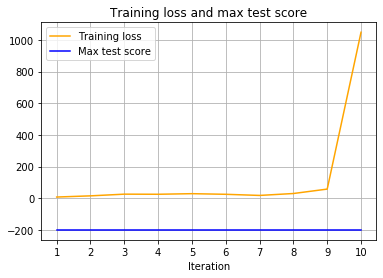

In [0]:
plt.plot(np.arange(1, 11, step = 1), dqn_training_loss, c = 'orange', label = 'Training loss')
plt.plot(np.arange(1, 11, step = 1), dqn_max_test_score, c = 'blue', label = 'Max test score')
#plt.axhline(1.715, c = 'gray', linestyle='dashed', label = 'Max possible score')
plt.xlabel('Iteration')
plt.grid(True)
plt.title('Training loss and max test score')
plt.xticks(np.arange(1, 11))
plt.legend()

Exporting results to a PKL file so that we can plot them together later

In [0]:
import pickle
with open('DQN-Loss-MountainCar.pkl', 'wb') as f:
  pickle.dump(dqn_training_loss, f)

## *SAC Agent*

## Implementation of SAC for discrete action space

* Below is an implementation of SAC in discrete action space in `tf.agent` according to the algorithm proposed in [P. Christodoulou 2019](https://arxiv.org/abs/1910.07207)

* The code is inspired by the pytorch implementation of the above algorithm found [here](https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/agents/actor_critic_agents/SAC_Discrete.py)

In [0]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tf_agents.agents import tf_agent
from tf_agents.policies import actor_policy
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.utils import eager_utils
from tf_agents.utils import nest_utils

Writing policy and computing losses

In [0]:
SacLossInfo = collections.namedtuple(
    'SacLossInfo', ('critic_loss', 'actor_loss', 'alpha_loss'))

class SacDisAgent(tf_agent.TFAgent):

  def __init__(self,
               time_step_spec,
               action_spec,
               critic_network,
               actor_network,
               actor_optimizer,
               critic_optimizer,
               alpha_optimizer,
               target_critic_network=None,
               target_critic_network_2=None,
               actor_policy_ctor=actor_policy.ActorPolicy,
               target_update_tau=1.0,
               target_update_period=1,
               td_errors_loss_fn=tf.math.squared_difference,
               gamma=1.0,
               reward_scale_factor=1.0,
               initial_log_alpha=0.0,
               gradient_clipping=None,
               debug_summaries=False,
               summarize_grads_and_vars=False,
               train_step_counter=None,
               name=None):
    tf.Module.__init__(self, name=name)

    flat_action_spec = tf.nest.flatten(action_spec)
    for spec in flat_action_spec:
      if not spec.dtype.is_integer:
        raise TypeError(
            'SacDisAgent is only for discrete action space. Use SacAgent for continuous'
        )

    self._critic_network_1 = critic_network
    self._critic_network_1.create_variables()
    self._target_critic_network_1 = (
        common.maybe_copy_target_network_with_checks(self._critic_network_1,
                                                     target_critic_network,
                                                     'TargetCriticNetwork1'))
    self._critic_network_2 = critic_network.copy(name="CriticNetwork2")
    self._critic_network_2.create_variables()
    self._target_critic_network_2 = (
        common.maybe_copy_target_network_with_checks(self._critic_network_2,
                                                     target_critic_network_2,
                                                     'TargetCriticNetwork2'))

    self._actor_network = actor_network
    self._actor_network.create_variables()

    policy = actor_policy_ctor(
        time_step_spec = time_step_spec,
        action_spec = action_spec,
        actor_network = self._actor_network,
        training=False
    )

    self._train_policy = actor_policy_ctor(
        time_step_spec = time_step_spec,
        action_spec = action_spec,
        actor_network = self._actor_network,
        training=True
    )

    self._log_alpha = common.create_variable(
        'initial_log_alpha',
        initial_value = initial_log_alpha,
        dtype = tf.float32,
        trainable=True
    )

    flat_action_spec = tf.nest.flatten(action_spec)
    target_entropy = -np.sum([
                              np.product(single_spec.shape.as_list())
                              for single_spec in flat_action_spec])

    self._target_update_tau = target_update_tau
    self._target_update_period = target_update_period
    self._actor_optimizer = actor_optimizer
    self._critic_optimizer = critic_optimizer
    self._alpha_optimizer = alpha_optimizer
    self._td_errors_loss_fn = td_errors_loss_fn
    self._gamma = gamma
    self._reward_scale_factor = reward_scale_factor
    self._target_entropy = target_entropy
    self._gradient_clipping = gradient_clipping
    self._debug_summaries = debug_summaries
    self._summarize_grads_and_vars = summarize_grads_and_vars
    self._update_target = self._get_target_updater(tau=self._target_update_tau, period=self._target_update_period)

    train_sequence_length = 2 if not critic_network.state_spec else None

    super(SacDisAgent, self).__init__(
        time_step_spec,
        action_spec,
        policy=policy,
        collect_policy=policy,
        train_sequence_length=train_sequence_length,
        debug_summaries=debug_summaries,
        summarize_grads_and_vars=summarize_grads_and_vars,
        train_step_counter=train_step_counter)
    
  def _initialize(self):
    "Operation that initialize the agent which copies all the parameters into the Q-network"
    common.soft_variables_update(
        self._critic_network_1.variables,
        self._target_critic_network_1.variables,
        tau=1.0)
    common.soft_variables_update(
        self._critic_network_2.variables,
        self._target_critic_network_2.variables,
        tau=1.0)
    
  def _experience_to_transitions(self, experience):
    transitions = trajectory.to_transition(experience)
    time_steps, policy_steps, next_time_steps = transitions
    actions = policy_steps.action
    if (self.train_sequence_length is not None and
        self.train_sequence_length == 2):
      # Sequence empty time dimension if critic network is stateless.
      time_steps, actions, next_time_steps = tf.nest.map_structure(
          lambda t: tf.squeeze(t, axis=1),
          (time_steps, actions, next_time_steps))
    return time_steps, actions, next_time_steps
    
  def _apply_gradients(self, gradients, variables, optimizer):
    grads_and_vars = list(zip(gradients, variables))
    if self._gradient_clipping is not None:
      grads_and_vars = eager_utils.clip_gradient_norms(grads_and_vars,
                                                        self._gradient_clipping)
    if self._summarize_grads_and_vars:
      eager_utils.add_variables_summaries(grads_and_vars,
                                        self.train_step_counter)
      eager_utils.add_gradients_summaries(grads_and_vars,
                                        self.train_step_counter)
    optimizer.apply_gradients(grads_and_vars)

  def _get_target_updater(self, tau=1.0, period=1):
    """Performs a soft update of the target network parameters.
    For each weight w_s in the original network, and its corresponding
    weight w_t in the target network, a soft update is:
    w_t = (1- tau) x w_t + tau x ws
    Args:
      tau: A float scalar in [0, 1]. Default `tau=1.0` means hard update.
      period: Step interval at which the target network is updated.
    Returns:
      A callable that performs a soft update of the target network parameters.
    """
    with tf.name_scope('update_target'):

      def update():
        """Update target network."""
        critic_update_1 = common.soft_variables_update(
            self._critic_network_1.variables,
            self._target_critic_network_1.variables,
            tau,
            tau_non_trainable=1.0)
        critic_update_2 = common.soft_variables_update(
            self._critic_network_2.variables,
            self._target_critic_network_2.variables,
            tau,
            tau_non_trainable=1.0)
        return tf.group(critic_update_1, critic_update_2)
      return common.Periodically(update, period, 'update_targets')

    
  def _actions_and_log_probs(self, time_steps):
    "get actions and corresponding probabilities from policy."
    
    batch_size = nest_utils.get_outer_shape(time_steps, self.time_step_spec)[0]
    policy_state = self._train_policy.get_initial_state(batch_size)
    action_distribution = self._train_policy.distribution(
        time_steps, policy_state = policy_state
    ).action

    actions = tf.nest.map_structure(lambda d: d.sample(), action_distribution)
    log_prob = common.log_probability(action_distribution, actions, self.action_spec)
    prob = tf.exp(log_prob)

    #tf.print("Probabilities: ", log_prob, prob, sep=">>>>\n")

    return actions, log_prob, prob

  def critic_loss(self,
                  time_steps,
                  actions,
                  next_time_steps,
                  td_errors_loss_fn,
                  gamma = 1.0,
                  reward_scale_factor = 1.0,
                  weights = None):
    "Computes the critic loss for training"

    with tf.name_scope('critic_loss'):
      tf.nest.assert_same_structure(actions, self.action_spec)
      tf.nest.assert_same_structure(time_steps, self.time_step_spec)
      tf.nest.assert_same_structure(next_time_steps, self.time_step_spec)

      next_actions, next_log_prob, next_prob = self._actions_and_log_probs(next_time_steps)
      target_input = (next_time_steps.observation, next_actions)
      target_q_values1, _ = self._target_critic_network_1(
          target_input, next_time_steps.step_type, training=False)
      target_q_values2, _ = self._target_critic_network_2(
          target_input, next_time_steps.step_type, training=False)
      target_q_values = (
          tf.minimum(target_q_values1, target_q_values2) -
          tf.exp(self._log_alpha) * next_log_prob)
      target_q_values = next_prob * target_q_values

      td_targets = tf.stop_gradient(
          reward_scale_factor * next_time_steps.reward +
          gamma * next_time_steps.discount * target_q_values)

      pred_input = (time_steps.observation, actions)
      pred_td_targets1, _ = self._critic_network_1(
          pred_input, time_steps.step_type, training=True)
      pred_td_targets2, _ = self._critic_network_2(
          pred_input, time_steps.step_type, training=True)
      critic_loss1 = td_errors_loss_fn(td_targets, pred_td_targets1)
      critic_loss2 = td_errors_loss_fn(td_targets, pred_td_targets2)
      critic_loss = critic_loss1 + critic_loss2

      if weights is not None:
        critic_loss *= weights

      if nest_utils.is_batched_nested_tensors(time_steps, self.time_step_spec, num_outer_dims=2):
        # Sum over the time dimension.
        critic_loss = tf.reduce_sum(input_tensor=critic_loss, axis=1)
      # Take the mean across the batch.
      critic_loss = tf.reduce_mean(input_tensor=critic_loss)

      if self._debug_summaries:
        td_errors1 = td_targets - pred_td_targets1
        td_errors2 = td_targets - pred_td_targets2
        td_errors = tf.concat([td_errors1, td_errors2], axis=0)
        common.generate_tensor_summaries('td_errors', td_errors,
                                         self.train_step_counter)
        common.generate_tensor_summaries('td_targets', td_targets,
                                         self.train_step_counter)
        common.generate_tensor_summaries('pred_td_targets1', pred_td_targets1,
                                         self.train_step_counter)
        common.generate_tensor_summaries('pred_td_targets2', pred_td_targets2,
                                         self.train_step_counter)


      return critic_loss

  def actor_loss(self, time_steps, weights=None):
    "Computes the actor loss for training"
    with tf.name_scope('actor_loss'):
      tf.nest.assert_same_structure(time_steps, self.time_step_spec)

      actions, log_prob, prob = self._actions_and_log_probs(time_steps)
      target_input = (time_steps.observation, actions)
      target_q_values1, _ = self._critic_network_1(target_input, time_steps.step_type, training=False)
      target_q_values2, _ = self._critic_network_2(target_input, time_steps.step_type, training=False)
      target_q_values = tf.minimum(target_q_values1, target_q_values2)
      actor_loss = tf.exp(self._log_alpha) * log_prob - target_q_values
      actor_loss = actor_loss * prob
      if nest_utils.is_batched_nested_tensors(time_steps, self.time_step_spec, num_outer_dims=2):
        actor_loss = tf.reduce_sum(input_tensor=actor_loss, axis=1)
      if weights is not None:
        actor_loss *= weights
      actor_loss = tf.reduce_mean(input_tensor=actor_loss)


      if self._debug_summaries:
        common.generate_tensor_summaries('actor_loss', actor_loss,
                                         self.train_step_counter)
        common.generate_tensor_summaries('actions', actions,
                                         self.train_step_counter)
        common.generate_tensor_summaries('log_pi', log_prob,
                                         self.train_step_counter)
        tf.compat.v2.summary.scalar(
            name='entropy_avg',
            data=-tf.reduce_mean(input_tensor=log_prob),
            step=self.train_step_counter)
        common.generate_tensor_summaries('target_q_values', target_q_values,
                                         self.train_step_counter)
        batch_size = nest_utils.get_outer_shape(
            time_steps, self._time_step_spec)[0]
        policy_state = self._train_policy.get_initial_state(batch_size)
        action_distribution = self._train_policy.distribution(
            time_steps, policy_state).action
        if isinstance(action_distribution, tfp.distributions.Normal):
          common.generate_tensor_summaries('act_mean', action_distribution.loc,
                                           self.train_step_counter)
          common.generate_tensor_summaries(
              'act_stddev', action_distribution.scale, self.train_step_counter)
        elif isinstance(action_distribution, tfp.distributions.Categorical):
          common.generate_tensor_summaries(
              'act_mode', action_distribution.mode(), self.train_step_counter)
        try:
          common.generate_tensor_summaries('entropy_action',
                                           action_distribution.entropy(),
                                           self.train_step_counter)
        except NotImplementedError:
          pass  # Some distributions do not have an analytic entropy.

      return actor_loss

  def alpha_loss(self, time_steps, weights=None):
    with tf.name_scope('alpha_loss'):
      tf.nest.assert_same_structure(time_steps, self.time_step_spec)

      actions, log_prob, log_pi = self._actions_and_log_probs(time_steps)
      log_pi = tf.reduce_sum(input_tensor = log_prob * prob)
      entropy_diff = tf.stop_gradient(-log_pi - self._target_entropy)
      alpha_loss = (self._log_alpha * entropy_diff)
      if nest_utils.is_batched_nested_tensors(time_steps, self.time_step_spec, num_outer_dims=2):
        alpha_loss = tf.reduce_sum(input_tensor=alpha_loss, axis=1)
      if weights is not None:
        alpha_loss *= weights

      alpha_loss = tf.reduce_mean(input_tensor=alpha_loss)
      return alpha_loss

  def _train(self, experience, weights):
    "trains with the provided batched experience"

    time_steps, actions, next_time_steps = self._experience_to_transitions(experience)

    trainable_critic_variables = (
        self._critic_network_1.trainable_variables +
        self._critic_network_2.trainable_variables
    )

    
    with tf.GradientTape(watch_accessed_variables=False) as tape:
      assert trainable_critic_variables, ('No trainable critic variables to optimize.')

      tape.watch(trainable_critic_variables)
      critic_loss = self.critic_loss(
          time_steps,
          actions,
          next_time_steps,
          td_errors_loss_fn = self._td_errors_loss_fn,
          gamma = self._gamma,
          reward_scale_factor = self._reward_scale_factor,
          weights = weights
      )
    tf.debugging.check_numerics(critic_loss, 'Critic loss is inf or nan.')
    critic_grads = tape.gradient(critic_loss, trainable_critic_variables)
    self._apply_gradients(critic_grads, trainable_critic_variables, self._critic_optimizer)

    trainable_actor_variables = self._actor_network.trainable_variables
    with tf.GradientTape(watch_accessed_variables=False) as tape:
      assert trainable_actor_variables, ('No trainable actor variables to optimize.')

      tape.watch(trainable_actor_variables)
      actor_loss = self.actor_loss(time_steps, weights=weights)
    tf.debugging.check_numerics(actor_loss, 'Actor loss is inf or nan.')
    actor_grads = tape.gradient(actor_loss, trainable_actor_variables)
    self._apply_gradients(actor_grads, trainable_actor_variables, self._actor_optimizer)

    alpha_variable = [self._log_alpha]
    with tf.GradientTape(watch_accessed_variables=False) as tape:
      assert alpha_variable, ("No alpha variable to optimize.")
      tape.watch(alpha_variable)
      alpha_loss = self.alpha_loss(time_steps, weights=weights)
    tf.debugging.check_numerics(alpha_loss, 'Alpha lost is inf or nan.')
    alpha_grads = tape.gradient(alpha_loss, alpha_variable)
    self._apply_gradients(alpha_grads, alpha_variable, self._alpha_optimizer)

    with tf.name_scope("Losses"):
      tf.compat.v2.summary.scalar(name='critic_loss', data=critic_loss, step=self.train_step_counter)
      tf.compat.v2.summary.scalar(name='actor_loss', data=actor_loss, step=self.train_step_counter)
      tf.compat.v2.summary.scalar(name='alpha_loss', data=alpha_loss, step=self.train_step_counter)

    self.train_step_counter.assign_add(1)
    self._update_target()

    total_loss = critic_loss + actor_loss + alpha_loss

    extra = SacLossInfo(
        critic_loss = critic_loss,
        actor_loss = actor_loss,
        alpha_loss = alpha_loss
    )

    return tf_agent.LossInfo(loss = total_loss, extra=extra)


      




```
`# This is formatted as code`
```

### Start to apply the SAC agent in the chosen environments

Trying to compare the performance of SAC discrete agent against the DQN. Start with importing the libraries

In [0]:
from tf_agents.drivers import dynamic_step_driver, dynamic_episode_driver
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.agents.ddpg import critic_network
from tf_agents.metrics import tf_metrics, py_metric, tf_py_metric
from tf_agents.networks import actor_distribution_network
from tqdm import tqdm

### Hyperparameters

To run the other environments, please update the env_name to Acrobot-v1 or MountainCar-v0

In [0]:
env_name = "CartPole-v0" # @param {type:"string"}
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000 # @param {type:"integer"} 
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 1000000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}
gradient_clipping = None # @param

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

log_interval = 5000 # @param {type:"integer"}

num_eval_episodes = 30 # @param {type:"integer"}
eval_interval = 1000 # @param {type:"integer"}

##### We will implement the same hyperparameters for Acrobot Environment

### Import the environments

In [0]:
train_py_env = suite_gym.load(env_name)

print('Observation Spec:')
print(train_py_env.time_step_spec().observation)
print('Reward Spec:')
print(train_py_env.time_step_spec().reward)
print('Action Spec:')
print(train_py_env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(2,), dtype=dtype('float32'), name='observation', minimum=[-1.2  -0.07], maximum=[0.6  0.07])
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(1,), dtype=dtype('float32'), name='action', minimum=-1.0, maximum=1.0)


In [0]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

### Agent

* Establish the Critic neural network and Actor neural network
* Initailize the SAC discrete agent

In [0]:
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()
critic_net = critic_network.CriticNetwork(
    (observation_spec, action_spec),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=critic_joint_fc_layer_params)


actor_net = actor_distribution_network.ActorDistributionNetwork(
    observation_spec,
    action_spec,
    fc_layer_params=actor_fc_layer_params)

In [0]:
global_step = tf.compat.v1.train.get_or_create_global_step()
sac_dis_agent = SacDisAgent(
    train_env.time_step_spec(),
    action_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries = True,
    train_step_counter=global_step)
sac_dis_agent.initialize()

In [0]:
sac_dis_agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

### Define replay buffer and trainning process

In [0]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    sac_dis_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity
)

def collect_training_data():
  dynamic_step_driver.DynamicStepDriver(
      train_env,
      sac_dis_agent.collect_policy,
      observers=[replay_buffer.add_batch],
      num_steps=initial_collect_steps).run()

def train_agent():
  dataset = replay_buffer.as_dataset(
      sample_batch_size=batch_size,
      num_steps=2)

  iterator = iter(dataset)

  loss = None
  for _ in tqdm(range(num_iterations)):
    trajectories, _ = next(iterator)
    loss = sac_dis_agent.train(experience=trajectories)
  
  print('\nTraining loss: ', loss.loss.numpy())
  print('\nTraining loss break down: Critic Loss {}, Actor Loss {}, Alpha Loss {}'.format(loss.extra.critic_loss.numpy(), loss.extra.actor_loss.numpy(), loss.extra.alpha_loss.numpy() ))
  return loss.loss.numpy()

### Define evaluation function with previously defined metrics

In [0]:
def evaluate_agent():
  max_score = TFMaxEpisodeScoreMetric() 
  observers = [max_score]
  driver = dynamic_episode_driver.DynamicEpisodeDriver(
      train_env, sac_dis_agent.policy, observers, num_episodes=num_eval_episodes)

  final_time_step, policy_state = driver.run()

  print('Max test score:', max_score.result().numpy())
  return max_score.result().numpy()

### Start training with GPU

In [0]:
import pickle

In [0]:
training_loss = []
max_test_score = []

with tf.device('/device:GPU:0'):
  for i in range(10):
    print('Step ', i+1)
    collect_training_data()
    training_loss.append(train_agent())
    max_test_score.append(evaluate_agent())
  
with open('MountCar_training_loss.pkl', 'wb') as f:
  pickle.dump(training_loss, f)

with open('MountCar_max_test_score.pkl', 'wb') as f2:
  pickle.dump(max_test_score, f2)

from google.colab import files
files.download('MountCar_training_loss.pkl')
files.download('MountCar_max_test_score.pkl')


Step  1


100%|██████████| 20000/20000 [16:08<00:00, 20.66it/s]



Training loss:  1668162200.0

Training loss break down: Critic Loss 1668415360.0, Actor Loss -253155.6875, Alpha Loss -27.56578254699707
Max test score: 39.949234
Step  2


100%|██████████| 20000/20000 [16:00<00:00, 20.80it/s]



Training loss:  5921013500000.0

Training loss break down: Critic Loss 5921048100864.0, Actor Loss -34847228.0, Alpha Loss -62.44685363769531
Max test score: 41.5313
Step  3


100%|██████████| 20000/20000 [16:06<00:00, 20.62it/s]



Training loss:  185252740000000.0

Training loss break down: Critic Loss 185252911775744.0, Actor Loss -160268736.0, Alpha Loss -99.24573516845703
Max test score: 58.562542
Step  4


100%|██████████| 20000/20000 [16:04<00:00, 20.74it/s]



Training loss:  1229401800000000.0

Training loss break down: Critic Loss 1229402176225280.0, Actor Loss -422640672.0, Alpha Loss -138.65367126464844


### Performance plot

In [0]:
import matplotlib.pyplot as plt

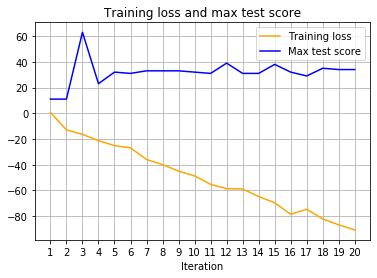

In [0]:
plt.plot(np.arange(1, 21, step = 1), training_loss, c = 'orange', label = 'Training loss')
plt.plot(np.arange(1, 21, step = 1), max_test_score, c = 'blue', label = 'Max test score')
#plt.axhline(1.715, c = 'gray', linestyle='dashed', label = 'Max possible score')
plt.xlabel('Iteration')
plt.grid(True)
plt.title('Training loss and max test score')
plt.xticks(np.arange(1, 21))
plt.legend()

## Apply SAC discrete on Atari games

### Hyperparameters

In [0]:
env_name = 'Boxing-ram-v0' # @param {type:"string"}
num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = 1000 # @param {type:"integer"} 
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 1000000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}
gradient_clipping = None # @param

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

log_interval = 5000 # @param {type:"integer"}

num_eval_episodes = 30 # @param {type:"integer"}
eval_interval = 10 # @param {type:"integer"}

In [0]:
train_py_env = suite_gym.load(env_name)

print('Observation Spec:')
print(train_py_env.time_step_spec().observation)
print('Reward Spec:')
print(train_py_env.time_step_spec().reward)
print('Action Spec:')
print(train_py_env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(210, 160, 3), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=17)


In [0]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

In [0]:
global_step = tf.compat.v1.train.get_or_create_global_step()
sac_dis_agent = SacDisAgent(
    train_env.time_step_spec(),
    action_spec,
    actor_network=actor_net,
    critic_network=critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=tf.compat.v1.losses.mean_squared_error,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries = True,
    train_step_counter=global_step)
sac_dis_agent.initialize()

In [0]:
training_loss = []
max_test_score = []

with tf.device('/device:GPU:0'):
  for i in range(20):
    print('Step ', i+1)
    collect_training_data()
    training_loss.append(train_agent())
    max_test_score.append(evaluate_agent())

Step  1


100%|██████████| 10000/10000 [20:43<00:00,  8.14it/s]



Training loss:  -0.40372062

Training loss break down: Critic Loss 0.00446342071518302, Actor Loss 2.5914273262023926, Alpha Loss -2.9996113777160645
Max test score: -56.0
Step  2


100%|██████████| 10000/10000 [21:17<00:00,  7.91it/s]



Training loss:  -2.6257899

Training loss break down: Critic Loss 0.00833912380039692, Actor Loss 3.364788055419922, Alpha Loss -5.998917102813721
Max test score: -56.0
Step  3


100%|██████████| 10000/10000 [21:02<00:00,  8.43it/s]



Training loss:  -5.7176065

Training loss break down: Critic Loss 0.013141793198883533, Actor Loss 3.269061803817749, Alpha Loss -8.999810218811035
Max test score: -56.0
Step  4


100%|██████████| 10000/10000 [20:59<00:00,  8.10it/s]



Training loss:  -8.677102

Training loss break down: Critic Loss 0.007756383623927832, Actor Loss 3.3190255165100098, Alpha Loss -12.003884315490723
Max test score: -56.0
Step  5


100%|██████████| 10000/10000 [21:11<00:00,  7.85it/s]



Training loss:  -11.835255

Training loss break down: Critic Loss 0.003748764283955097, Actor Loss 3.168954849243164, Alpha Loss -15.00795841217041
Max test score: -56.0
Step  6


100%|██████████| 10000/10000 [20:56<00:00,  8.40it/s]



Training loss:  -15.0280485

Training loss break down: Critic Loss 0.002143287332728505, Actor Loss 2.9754538536071777, Alpha Loss -18.005645751953125
Max test score: -56.0
Step  7


 93%|█████████▎| 9265/10000 [19:42<01:28,  8.30it/s]

KeyboardInterrupt: ignored

### code for plotting

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import normalize

#### import the lists

First get the CartPole data

In [0]:
dire = './plot_data'

with open(dire + '/' + 'CartPole_training_loss.pkl', 'rb') as f:
    ctl = pickle.load(f)
with open(dire + '/' + 'CartPole_max_test_score.pkl', 'rb') as f:
    cmt = pickle.load(f)
with open(dire + '/' + 'DQN-Loss-CrtPole.pkl', 'rb') as f:
    dtl = pickle.load(f)
with open(dire + '/' + 'DQN-MaxScore-CrtPole.pkl', 'rb') as f:
    dmt = pickle.load(f)

Then get the Acrobot

In [0]:
with open(dire + '/' + 'Acrobat_training_loss.pkl', 'rb') as f:
    ctl_acro = pickle.load(f)
with open(dire + '/' + 'Acrobat_max_test_score.pkl', 'rb') as f:
    cmt_acro = pickle.load(f)
with open(dire + '/' + 'DQN-Loss-Acrobot.pkl', 'rb') as f:
    dtl_acro = pickle.load(f)
with open(dire + '/' + 'DQN-MaxScore-Acrobot.pkl', 'rb') as f:
    dmt_acro = pickle.load(f)

Now get the Mountain Cart

In [0]:
with open(dire + '/' + 'MountCar_training_loss.pkl', 'rb') as f:
    ctl_mc = pickle.load(f)
with open(dire + '/' + 'MountCar_max_test_score.pkl', 'rb') as f:
    cmt_mc = pickle.load(f)
with open(dire + '/' + 'DQN-Loss-MountainCar.pkl', 'rb') as f:
    dtl_mc = pickle.load(f)
with open(dire + '/' + 'DQN-MaxScore-MountainCar.pkl', 'rb') as f:
    dmt_mc = pickle.load(f)

In [0]:
fig, axs = plt.subplots(3,2, figsize=(18, 16))
axs[0,0].plot(np.arange(1, 11, step = 1), normalize(np.array(ctl).reshape(-1,1), axis=0).flatten(), c='orange', label = 'SAC-Discrete')
axs[0,0].plot(np.arange(1, 11, step = 1), normalize(np.array(dtl).reshape(-1,1), axis=0).flatten(), c='blue', label = 'DQN')
axs[0, 0].set_title('Cart Pole Normalized Training Losses')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Normalized Loss')
axs[0,1].plot(np.arange(1, 11, step = 1), cmt, c='orange', label = 'SAC-Discrete')
axs[0,1].plot(np.arange(1, 11, step = 1), dmt, c='blue', label = 'DQN')
axs[0, 1].set_title('Cart Pole Max Scores')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Score')
axs[1,0].plot(np.arange(1, 11, step = 1), normalize(np.array(ctl_acro).reshape(-1,1), axis=0).flatten(), c='orange', label = 'SAC-Discrete')
axs[1,0].plot(np.arange(1, 11, step = 1), normalize(np.array(dtl_acro).reshape(-1,1), axis=0).flatten(), c='blue', label = 'DQN')
axs[1, 0].set_title('Acrobot Normalized Training Losses')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Normalized Loss')
axs[1,1].plot(np.arange(1, 11, step = 1), cmt_acro, c='orange', label = 'SAC-Discrete')
axs[1,1].plot(np.arange(1, 11, step = 1), dmt_acro, c='blue', label = 'DQN')
axs[1, 1].set_title('Acrobot Normalized Max Scores')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Score')
axs[2,0].plot(np.arange(1, 11, step = 1), normalize(np.array(ctl_mc).reshape(-1,1), axis=0).flatten(), c='orange', label = 'SAC-Discrete')
axs[2,0].plot(np.arange(1, 11, step = 1), normalize(np.array(dtl_mc).reshape(-1,1), axis=0).flatten(), c='blue', label = 'DQN')
axs[2, 0].set_title('Mountain Car Training Losses')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].set_ylabel('Normalized Loss')
axs[2,1].plot(np.arange(1, 11, step = 1), cmt_mc, c='orange', label = 'SAC-Discrete')
axs[2,1].plot(np.arange(1, 11, step = 1), dmt_mc, c='blue', label = 'DQN')
axs[2, 1].set_title('Mountain Car Normalized Max Scores')
axs[2, 1].set_xlabel('Epoch')
axs[2, 1].set_ylabel('Score')

for ax in axs.flat:
    ax.legend()

fig.savefig('result.png', bbox_inches='tight')